# Visit selection, custom coadd construction and characterization

version: **Weekly_2022_40** <br>
Container Size: Large 

**Description:** In this notebook we make a selection of visits that meet image quality requirements (airmass, PSF size mean and std for the visit) given by the user together with the band and sky coordinates (RA, DEC). Then using the selected visits we create a custom coadd and run the image characterization task. 

**Contributor:** K.A. Alamo-Martinez


---
---

# Set up

In [1]:
! echo $IMAGE_DESCRIPTION

Weekly 2022_40


In [2]:
### Rubin-specific packages
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')
from lsst.rsp import get_tap_service
import lsst.afw.table as afwTable
import lsst.daf.base as dafBase
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

### General python / astronomy packages
import math, time, getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord

# To ignore some kinds of warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Instantiate the butler to have access to DPO.2 data
repo = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(repo, collections=collection)

# read visit table to extract airmass values
visitTableRef = list(butler.registry.queryDatasets('visitTable'))
visitTable = butler.get(visitTableRef[0])

# read ccd table to extract psfSigma and seeing values
ccdTableRef = list(butler.registry.queryDatasets('ccdVisitTable'))
ccdTable = butler.get(ccdTableRef[0])

# 1. Visits selection

In order to select the visits that meet the given quality requirements we need a band and sky position to extract the patch and tract. Then, we retrieve the list of visits used to construct the _default_ deepCoadd. From the visits list we finally select the ones that follow the PSF size and airmass constraints.


In [4]:

def visit_selection(ra_deg, dec_deg, band, psfSigma_cut, psfStd_cut, airmass_cut):
    ''' For a given band and sky position this function selects the visits that 
    meet the given quality requirements: PSFsize mean (psfSigma_cut), 
    PSFsize standard deviation (psfStd_cut), and airmass (airmass_cut). 
    It returns the list of visits and a figure with all the visits 
    highlighting the selected subset'''
    # with the sky coordinates, we identify the tract and patch that cover the desired region
    point_sky = geom.SpherePoint(ra_deg, dec_deg, geom.degrees)
    skymap = butler.get('skyMap')
    my_tractInfo = skymap.findTract(point_sky)
    my_tract = my_tractInfo.tract_id
    my_patch = my_tractInfo.findPatch(point_sky).getSequentialIndex()

    # read from butler the coadded image that contains the given coordinates
    coaddId = {'band': band, 'tract': my_tract, 'patch': my_patch}
    coadd = butler.get("deepCoadd", dataId = coaddId)
    coadd_inputs = coadd.getInfo().getCoaddInputs()
    
    # list of visits used to contruct the deepCoadd
    visit_list = coadd_inputs.visits['id']
    
    dataset = {}
    n_visits = len(visit_list)
    xticklabels =[]
    metrics = np.empty((0,7), float)

    for i,v in enumerate(visit_list[0:n_visits]):
        # the try and except was included because for some 
        # visits there is missing data for some CCDs resulting in error
        try:
            dataId = {'visit':v,'detector': 0} 
            xticklabels.append(v)
            # values from ccd table
            psfSigma_mean = ccdTable['psfSigma'][ccdTable['visitId'] == v].mean()
            seeing_mean = ccdTable['seeing'][ccdTable['visitId'] == v].mean()
            psfSigma_std = ccdTable['psfSigma'][ccdTable['visitId'] == v].std()
            seeing_std = ccdTable['seeing'][ccdTable['visitId'] == v].std()
            # values from visit table
            airmass = visitTable['airmass'][visitTable['visit'] == v]
            #obsStartMJD = visitTable['obsStartMJD'][visitTable['visitId'] == v] #to select by observing time
            
            metrics = np.append(metrics, np.array([[i, v, airmass, psfSigma_mean, psfSigma_std, seeing_mean, seeing_std]]), axis=0)
        except:
            pass

    df_metrics = pd.DataFrame(data= metrics, columns = ['id_plot', 'visit_id', 'airmass', 'psfSigma_mean', 'psfSigma_std', 'seeing_mean', 'seeing_std'])
    df_metrics['visit_id'] = df_metrics['visit_id'].astype('int')
    df_metrics['psfSigma_std'] = df_metrics['psfSigma_std'].astype('float')
    df_metrics['airmass'] = df_metrics['airmass'].astype('float')
    df_metrics['id_plot'] = df_metrics['id_plot'].astype('int')

    # apply constraints
    visits_selected = df_metrics[(df_metrics['psfSigma_mean'] <= psfSigma_cut) & (df_metrics['psfSigma_std'] <= psfStd_cut) & (df_metrics['airmass'] <= airmass_cut)]
    
    ########## PLOT ##########
    if band in 'ugz': size_visit = 8
    else: size_visit = 5
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sc = ax.scatter(df_metrics['id_plot'], df_metrics['psfSigma_mean'], s = df_metrics['psfSigma_std']*20000, c = df_metrics['airmass'], cmap = 'viridis', alpha=0.4)
    # to highlight the selected ones
    ax.scatter(visits_selected['id_plot'], visits_selected['psfSigma_mean'], s = visits_selected['psfSigma_std']*20000, fc='none', linewidths=1.5, ec='red') 
    ax.set_xticks(range(len(df_metrics)))
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.tick_params(axis='x', which='major', labelsize=size_visit)
    ax.set_xticklabels(xticklabels, rotation = 90)
    ax.set_xlabel('Visit ID', fontsize=14)
    ax.set_ylabel('PSF size', fontsize=14)
    ax.set_xlim(0,len(df_metrics))
    ax.axhline(y = psfSigma_cut, lw=3, ls='--', color='k', alpha=0.5)
    ax.axvline(x = 5, ymin = 2.75, ymax = 2.9, lw=3, ls='--', color='k', alpha=0.5)
    plt.colorbar(sc, ax = ax, label='airmass')
    fig.suptitle(band + " band", fontsize=16);
        
    return visits_selected['visit_id']


Since this is only an example, in order to have a reasonable running time for the coadd construction, we choose constraint values that resulted in ~10 visits. 

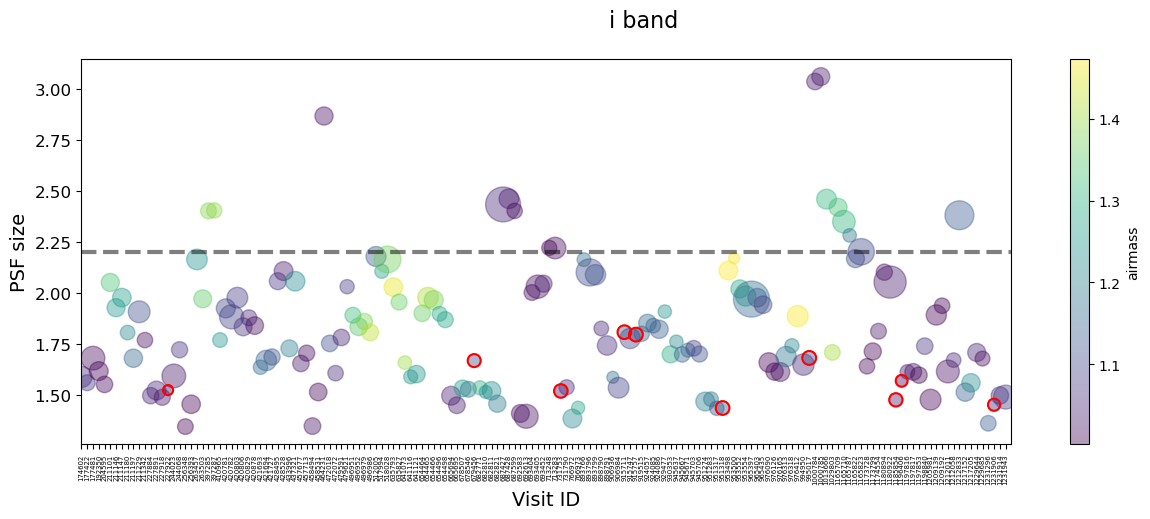

In [5]:

#visit_selection(ra_deg, dec_deg, band, psfSigma_cut, psfStd_cut, airmass_cut)
visits_selected = visit_selection(55.745834, -32.269167, 'i', 2.2, 0.005, 1.15)


In [6]:
len(visits_selected)

10

## 2. Custom coadd construction

This section follows the DP0.2 tutorials [9a](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_09_Custom_Coadds/DP02_09a_Custom_Coadd.ipynb) and [9b](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_09_Custom_Coadds/DP02_09b_Custom_Coadd_Sources.ipynb).

In [7]:
## create a tuple with the visits for coadding
my_visits_tupleString = "("+",".join(visits_selected.astype(str))+")"
print(my_visits_tupleString)

(227922,679456,731753,915711,915757,951318,995017,1185854,1196406,1231906)


In [8]:
## list all the collections under 'kalamo'
#!butler query-collections dp02 --chains=tree u/kalamo/*

In [9]:
# Name for output collection
band = 'i'
ra_deg = 55.745834
dec_deg = -32.269167

point_sky = geom.SpherePoint(ra_deg, dec_deg, geom.degrees)
skymap = butler.get('skyMap')
my_tractInfo = skymap.findTract(point_sky)
my_tract = my_tractInfo.tract_id
my_patch = my_tractInfo.findPatch(point_sky).getSequentialIndex()
    
my_username = getpass.getuser()
my_outputCollection = 'u/'+my_username+'/custom_coadd_' + band + '_test01'
print('Name of new butler collection for my output: ', my_outputCollection)

Name of new butler collection for my output:  u/kalamo/custom_coadd_i_test01


Here we use the _SimplePipelineExecutor_, a high-level executor for pipelines that is primarily used for unit tests and small-scale integration of pipeline tasks. 

In [10]:
# set up the butler for the new collection
simpleButler = SimplePipelineExecutor.prep_butler('dp02', 
                                                  inputs=['2.2i/runs/DP0.2'], 
                                                  output=my_outputCollection)

simpleButler.registry.getCollectionChain(my_outputCollection)

CollectionSearch(('u/kalamo/custom_coadd_i_test01/20231221T200725Z', '2.2i/runs/DP0.2'))

In [11]:
## selection of makeWarp and assembleCoadd pipeline tasks
assembleCoaddPipeline = Pipeline.from_uri('$DRP_PIPE_DIR/pipelines/LSSTCam-imSim/DRP-test-med-1.yaml#makeWarp,assembleCoadd') 

# configuration
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)
assembleCoaddPipeline.addConfigOverride('makeWarp', 'connections.visitSummary', "visitSummary")

In [12]:
# the custom coadd will have the same skymap (i.e. tract and patch) as the default deepCoadd
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

In [13]:
# Set up the Simple Pipeline Executor
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

In [14]:
# Run the pipeline
quanta = spe.run()

## Display of default and custom coadds

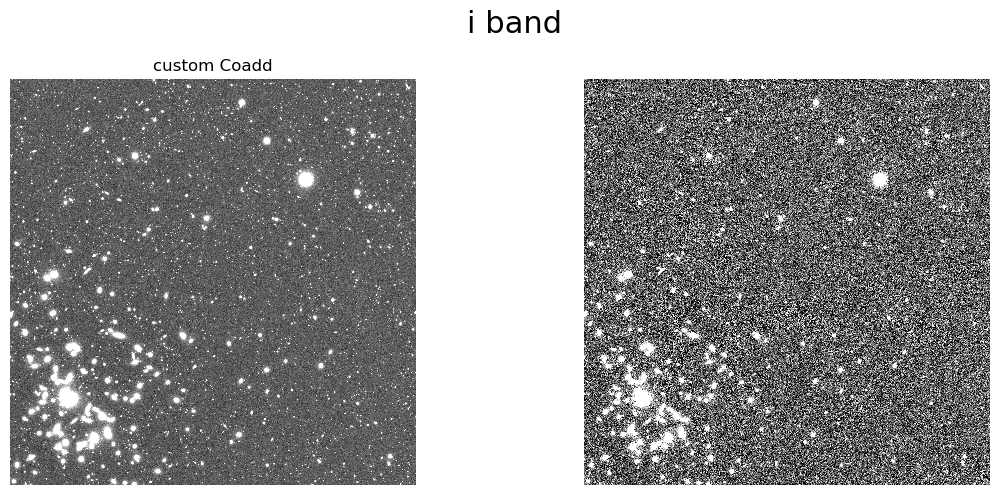

In [15]:
# Default/original coadd
config1 = 'dp02'
collection1 = '2.2i/runs/DP0.2'
butler1 = Butler(config1, collections=collection1)
my_dataId1 = {'band': band, 'tract': my_tract, 'patch': my_patch}

# custom coadd constructed with the subset of selected visits
config2 = "dp02"
collection2 = my_outputCollection
butler2 = Butler(config2, collections=collection2)
my_dataId2 = {'band': band, 'tract': my_tract, 'patch': my_patch}

default_deepCoadd = butler1.get('deepCoadd', dataId=my_dataId1)
custom_Coadd = butler2.get('deepCoadd', dataId=my_dataId2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(band + " band", fontsize=22)

plt.sca(ax[0])  
display1 = afwDisplay.Display(frame=fig) 
# use the same scale (linear with fix min and max values) for both images to visualiza differences
display1.scale('linear', min=-0.3, max=0.5)
#display1.scale('asinh', 'zscale')
display1.mtv(default_deepCoadd.image)
display1.show_colorbar(False)
ax[0].axis('off')
ax[0].set_title('original deepCoadd')

plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', min=-0.3, max=0.5)
display2.mtv(custom_Coadd.image)
display2.show_colorbar(False)
ax[1].axis('off')
ax[0].set_title('custom Coadd')

plt.tight_layout()
plt.show()

## Image characterization (detection, measurement and PSF construction)

In [16]:
tap_service = get_tap_service()

In [17]:
custom_coadd = butler2.get('deepCoadd', dataId=my_dataId2)
custom_coadd_inputs = custom_coadd.getInfo().getCoaddInputs()
custom_coadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
227922,11900,7900,16099,12099,1512880,1.745271720648272,i_sim_1.4
679456,11900,7900,16099,12099,16041447,4.604355690621661,i_sim_1.4
731753,11900,7900,16099,12099,16089493,1.3381987858278837,i_sim_1.4
915711,11900,7900,16099,12099,15982751,4.451979636268421,i_sim_1.4
915757,11900,7900,16099,12099,16137923,4.558204699511925,i_sim_1.4
951318,11900,7900,16099,12099,1109521,4.492243638075162,i_sim_1.4
995017,11900,7900,16099,12099,15134050,1.3442424093358412,i_sim_1.4
1185854,11900,7900,16099,12099,210658,4.3341408182588435,i_sim_1.4


In [21]:
# Create a basic schema
schema = afwTable.SourceTable.makeMinimalSchema()
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)

config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
sourceDeblendTask = SourceDeblendTask(schema=schema)

algMetadata = dafBase.PropertyList()
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

In [22]:
# run characterization (PSF construction)
result_ci = charImageTask.run(custom_coadd)

In [23]:
bbox = custom_coadd.getBBox()
center = geom.Point2D(bbox.centerX, bbox.centerY)
psf = custom_coadd.getPsf()
sigma = psf.computeShape(center).getDeterminantRadius()
scale = custom_coadd.wcs.getPixelScale().asArcseconds()
print('PSF FWHM = {:.2f} arcsec'.format(sigma * scale * 2.355))
del bbox, center, psf, sigma, scale

PSF FWHM = 0.80 arcsec


In [24]:
# source detection
srctab = afwTable.SourceTable.make(schema)
result_sd = sourceDetectionTask.run(srctab, custom_coadd)
sources = result_sd.sources

In [25]:
#deblending
sourceDeblendTask.run(custom_coadd, sources)

In [26]:
# final measuring
sourceMeasurementTask.run(measCat = sources, exposure = custom_coadd)

In [27]:
sources = sources.copy(True)
my_sources = sources.asAstropy()

my_sources.add_column('i_CalibMag_AB')
my_sources['i_CalibMag_AB'] = np.zeros(len(my_sources), dtype='float')
custom_coadd_photoCalib = custom_coadd.getPhotoCalib()
for s in range(len(my_sources)):
    my_sources['i_CalibMag_AB'][s] = \
    custom_coadd_photoCalib.instFluxToMagnitude(my_sources['slot_CalibFlux_instFlux'][s])

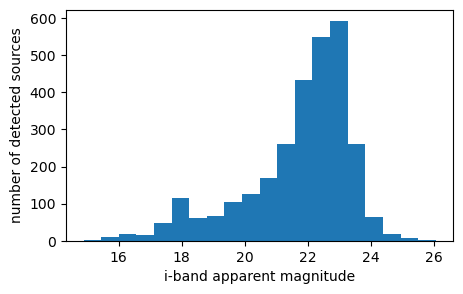

In [28]:
plt.figure(figsize=(5, 3))
plt.hist(my_sources['i_CalibMag_AB'], bins=20)
plt.xlabel('i-band apparent magnitude')
plt.ylabel('number of detected sources')
plt.show()